<h2 align="center">
    Creating a live interactive portrait using video textures.
</h2>
<h3 align="center">
    Oscar Martinez &lt;omtinez@gatech.edu&gt; 2015
</h3>

### Introduction
In this document a technique for creating an interactive portrait is described. The technique is also applicable to the creation of many other forms of interactive videos and is based on concepts of computational photography and computer vision, including video textures. Instead of creating a single video texture from a set of frames, a set of frame sequences capturing actions is created from a series of provided key frames. The algorithm consists of finding the best sequence between each individual action and a *steady-state* action, then presenting the result to the user in an interactive application.

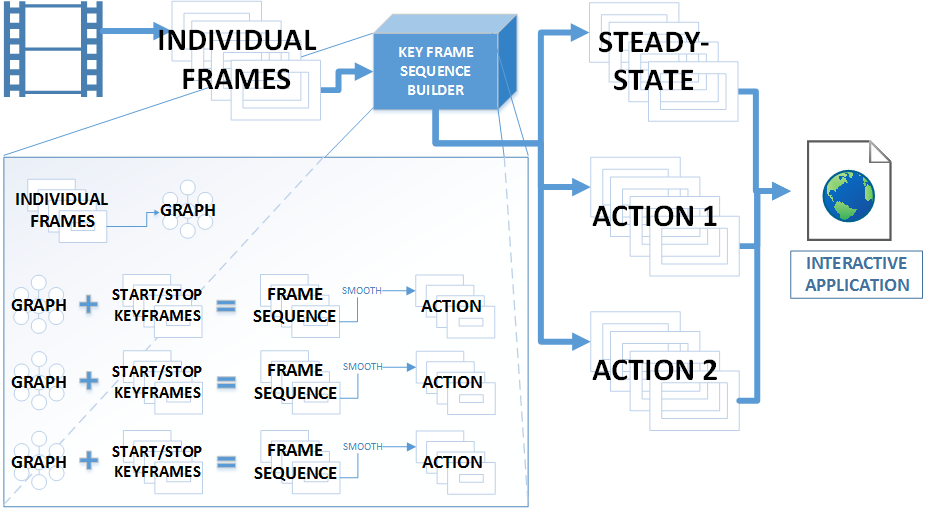

In [2]:
from IPython.display import display, Image
Image('pipeline.png')

### Shortest Path Between Frames

The core of the technique for creating an interactive video is finding a smooth sequence of frames between any two arbitrary frames. To achieve this, like in video textures, a distance matrix representing the (un)likeness of all pairs of frames is computed. This could be interpreted as a directed graph with each frame as a node and each matrix cell as the edge representing  the cost of transitioning from one frame to another. The distance function between two frames *F<sub>i</sub>* and *F<sub>j</sub>* is computed as the sum of squared distances:

$$S.S.D.: \quad D_{ij}=\sum(F_i-F_j)^2 \quad \forall \: i,j$$

In [2]:
def generatingKernel(p):
    ''' Return a 5x5 generating kernel based on an input parameter. '''
    kernel = np.array([.25 - p / 2.0, .25, p, .25, .25 - p /2.0])
    return np.outer(kernel, kernel)

def reduce(image):
    ''' Convolve the input image with a generating kernel of parameter of 0.4 and
    then reduce its width and height in half. '''
    return convolve2d(image, generatingKernel(0.3), 'same')[::2,::2]

def SSD(video_volume):
    ''' Compute the sum of squared differences between all pairs of frames in a video volume '''
    output = np.zeros((len(video_volume), len(video_volume)), dtype=np.float)
    video_volume_blur = [reduce(f).astype(np.float) for f in video_volume]
    for i in range(len(video_volume)):
        curr_frame = video_volume_blur[i].astype(np.float)
        for j in range(len(video_volume_blur)):
            if i < j:
                output[i,j] = ((curr_frame - video_volume_blur[j]) ** 2).sum()
            elif i > j:
                output[i,j] = output[j,i]
    return output

However, taking every possible transition into account would yield a problem impractical to solve due to its size. To remedy that, before trying to find the shortest path between two frames, only the top *N* edges with the shortest distance metric are sampled. *N* could be any arbitrary number and, in the example provided, `100` was found to be a good compromise between efficiency and the quality of the output.

In [3]:
def bestTransitions(ssd_matrix, transitions=100):
    ''' Find the subset of smallest transitions between frames '''
    L = ssd_matrix.shape[0]
    
    # Best transitions from i to j
    ij = np.array([np.argpartition(l, transitions)[:transitions] for l in ssd_matrix])
    # Best transitions from j to i (not strictly necessary due to simmetry)
    ji = np.array([[i for i in range(L) if j in ij[i]] for j in range(L)])
    
    # Build dependency maps to recover original edges after sampling
    graphix = np.array([np.array(['%d_%d' % (i,j) 
                  for j in ij[i]]) for i in range(L)]).flatten()
    graphmap = {graphix[x]:x for x in range(len(graphix))}
    
    return ij, ji, graphix, graphmap

From the numerous possibilities to compute the shortest path between two frames in the graph containing only a subset of the original edges, a linear programming formulation was chosen. Given a directed graph *(V, A)* with source node *s*, target node *t*, and cost *w<sub>ij</sub>* for each edge *(i,j)* in *A*, consider the program with variables *x<sub>ij</sub>* in which the objective function is to minimize:

$$\sum_{ij \in A} w_{ij} x_{ij}$$

Subject to the following constraints:

$$x_{ij} \ge 0 \quad \forall \: ij \in A$$

$$\sum_j x_{ij} - \sum_j x_{ji} = \begin{cases}1, &\text{if }i=s;\\ -1, &\text{if }i=t;\\ 0, &\text{ otherwise.}\end{cases} \quad \forall \: i$$

It is worth noting that, unlike approximation algorithms, this algorithm will find the shortest path if feasible or it will not find a path at all. In this implementation, *Scipy*'s version of Dantzig's simplex algorithm (Dantzig, Orden & Wolfe, 1955) was used as a solver. Since only a subset of all edges is considered, the likelihood of not finding a possible path is inversely proportional to the choice of *N*. At the same time, as *N* grows, the computational resources necessary to find a solution increase rapidly.

When the constraints describe a feasible problem, a subset of all frames is found with the smallest transitions between them that start at the provided start frame and end at the provided end frame.

In [4]:
def linprogParams(ssd_matrix, ij, ji, graphix, graphmap, s, t):
    ''' Compute the linear programming parameters for the given problem '''
    L = ssd_matrix.shape[0]
    
    # 2-D array which, when matrix-multiplied by x, gives the values 
    # of the equality constraints at x
    A = np.zeros((L,len(graphmap)), dtype=np.int)
    for n in range(L):
        for i in ij[n]: A[n,graphmap['%d_%d' % (n,i)]] += 1
        for j in ji[n]: A[n,graphmap['%d_%d' % (j,n)]] -= 1
            
    # Coefficients of the linear objective function to be minimized
    c = np.zeros((len(graphix),))
    for n in range(len(graphix)):
        x,y = graphix[n].split('_')
        x = int(x)
        y = int(y)
        c[n] = ssd_matrix[x,y]
        
    # 1-D array of values representing the RHS of each equality 
    # constraint (row) in A
    b = np.zeros((L,))
    b[s] = 1
    b[t] = -1
    
    return c, A, b

### Frame Blending and Insertion

After an optimal path has been found, there may still be a significant difference between some of the ordered frames. Such *gap*, even if it occurs only between a single pair of frames, has a very negative impact on the overall quality of the result. Given a sequence of frames describing an optimal path, the same sum of squared differences described above is computed for each pair of consecutive frames. Using the relative value of the standard deviation of the S.S.D. with respect to the mean as a basic outlier detection method, the most significant *gaps* between frames, if any, are found. To ease the transition between two frames *F<sub>a</sub>* and *F<sub>b</sub>*, new transition frames *T<sub>i</sub>* are inserted in between such that:

$$\alpha_i = i / n, \quad i \in 1..n$$

$$T_i = \alpha_i \cdot f(F_a) + (1-\alpha_i) \cdot f(F_b)$$

With *f(x)* being a simple Gaussian kernel. The resulting sequence is significantly more visually appealing, almost always removing entirely the visual discordance with just a handful of frames inserted.

In [5]:
def transitionFrames(frame1, frame2, numFrames=10):
    ''' Compute transition frames between two given frames '''
    blur1 = gaussian_filter(frame1, sigma=(.1,.1,0), order=0).astype(np.float)
    blur2 = gaussian_filter(frame2, sigma=(.1,.1,0), order=0).astype(np.float)
    blend = lambda alpha: (blur1*alpha + blur2*(1-alpha)).astype(np.uint8)
    return [blend(alpha) for alpha in np.linspace(1,0,numFrames)]
        
def easeTransitions(frameList, max_insertions=4):
    ''' Smooth out the worst transitions between consecutive frames '''
    
    for i in range(max_insertions):
        
        # Compute frame differences
        deltas = np.array([((frameList[i] - frameList[i+1]) ** 2).sum() 
                     for i in range(len(frameList)-1)])
        frameIndex = np.argmax(deltas) + 1

        # Done if no outliers are found
        if deltas.std() < deltas.mean(): break
            
        # Insert transition frames
        midFrames = transitionFrames(frameList[frameIndex-1], frameList[frameIndex])
        frameList = frameList[:frameIndex] + midFrames + frameList[frameIndex:]
        
    return frameList

### Key Frames and Actions

With the tools necessary to create a smooth sequence between any two arbitrary frames, a lot of interesting video effects can be created. Standard video textures can easily be achieved, but they can now contain any frame of choice as part of the resulting sequence, namely *key frames*. The sequence may or may not end at the same starting frame, but it must contain all key frames and have a smooth transition between all consecutive pairs of frames.

For the provided implementation, a short video portrait was taken and a number of *actions* were performed during the video. For each action, 3 key frames are identified: prior to the action starting, in the middle of the action, and just after the action is over. This is done because, for actions that end in a similar state compared to where they started, the shortest path likely skips the action entirely if only the beginning and end frames are chosen as key frames.

When the key frames are all provided simultaneously, they can also be mutually excluded from one another's descriptive actions. For example, if containing other actions' key frames was not penalized, the smoothest sequence in the portrait video between the initial state and the action of smiling was found to be through the action of sticking the tongue out. While that might indeed be the most optimal sequence of frames, it is desirable to isolate the actions in their own frame sequence. To achieve that, the frame distance matrix is altered to increase the values that represent the transitions to and from all the other key frames so the sampling of edges is less likely to capture them.

In [6]:
def smoothSequence(videoName, startFrame, endFrame, action=0, transitions=100, ssd_matrix=None):
    ''' Find the smoothest and shortest possible sequence between two frames '''
    
    print('Computing difference matrix...')
    if ssd_matrix is None: ssd_matrix = SSD(videoVolume(videoname))
    
    print('Selecting %d best transitions for each frame...' % transitions)
    ij, ji, graphix, graphmap = bestTransitions(ssd_matrix, transitions=transitions)
    
    print('Populating linear programming parameters...')
    c, A, b = linprogParams(ssd_matrix, ij, ji, graphix, graphmap, startFrame, endFrame)
    
    print('Solving linear equations...')
    res = linprog(c, A_eq=A, b_eq=b, options={"disp": True})
    
    print('Ordering the transitions between frames...')
    unordered_transitions = [graphix[i] for i in range(len(res.x)) if res.x[i] > 0]
    nextFrame = lambda x: [int(t.split('_')[1]) 
                  for t in unordered_transitions if t.startswith('%d_' % x)][0]
    frameList = [startFrame]
    for i in range(len(unordered_transitions)):
        frameList += [nextFrame(frameList[-1])]
        
    print('Loading %d frames from input video...' % len(frameList))
    candle = lambda x: 'frame%04d.png' % (1+int(x))
    imlist = [join(videoname,candle(f)) for f in frameList]
    images = [ndimage.imread(img, mode='RGB') for img in imlist]
    
    print('Smoothing transitions between frames...')
    images = easeTransitions(images)
    
    print('Writing %d ordered frames to output location...' % len(images))
    fname, ext = splitext(imlist[0])
    for i,img in enumerate(images):
        toimage(img, cmin=0.0, cmax=...).save(join('out','A%03d_F%03d%s' % (action,i,ext)))
        
    # Return the number of frames output
    return len(images)

def keyFrameSequence(videoName, framelist, avoidFrames=[], loop=True, transitions=100):
    ''' Find the smoothest and shortest possible sequence containing a set of key frames '''
    
    vidLen = 0
    action = 0
    
    # Compute the diff matrix
    ssd_matrix = SSD(videoVolume(videoname))
    
    # Add the first frame at the end if looping around
    if loop: framelist += [framelist[0]]
    for i in range(len(framelist)-1):
        
        # Make a copy of the diff matrix and penalize other key frames
        diffMatrix = ssd_matrix.copy()
        for frame in framelist+avoidFrames:
            if frame == framelist[i] or frame == framelist[i+1]: continue
            diffMatrix[frame-12:frame+12] = diffMatrix.max() * 2
            diffMatrix.T[frame-12:frame+12] = diffMatrix.max() * 2
            
        # Find the sequence of frames between key frmaes
        vidLen += smoothSequence(videoName, framelist[i], framelist[i+1], 
                      action=action, transitions=transitions, ssd_matrix=diffMatrix)
        action += 1
    return vidLen

### Interactive Visualization

The result of the previously described steps yield a series of frame sequences, which groups into a set of actions. If the state of the scene is similar at the start and end of the action, like in all of the actions performed in the portrait video, the sequences can be organized in a way such that each action begins at and returns to a *steady state*. A video file could be created by combining all those actions in any order of choice, but a more interactive approach was taken instead. 

To convey aliveness in the scene, the viewer is presented with a video texture that loops between the steady state and some very minor action, in the case of the video portrait that action being simply eyes blinking. Then, a number of buttons are provided which make the subject in the video take an action of choice interactively.

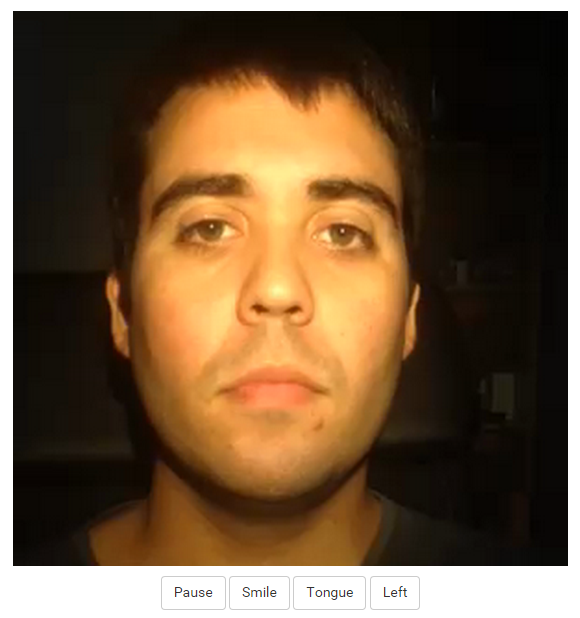

In [9]:
Image('ui.png', height=300, width=300)

### Other Applications

Combined with other computational photography and computer vision techniques, a number of other applications become available based on this work. For example, adding automatic key frame detection would make an interesting video summarization implementation. With the help of action recognition, the implementation described here can also be used in the process of extracting those actions from raw video. Also, even though computer generated graphics are nowadays virtually indistinguishable from actual footage, the concept of interactive videos can be used in the context of user interfaces such as digital assistants.


### Sample Implementation

The code below takes a folder containing all the frames from a portrait video as input and outputs all the frame sequences for all the actions occurring at the specified key frames. The resulting frames are then presented in an interactive application ready to use in most desktop web browsers at http://omtinez.com/portrait/.

In [8]:
import numpy as np
from scipy import ndimage
from scipy.misc import toimage
from scipy.optimize import linprog 
from scipy.signal import convolve2d 
from scipy.ndimage.filters import gaussian_filter

import re
import shutil
from os import listdir, unlink
from os.path import isfile, join, splitext

def imread(impath):
    ''' Utility function used to read an image into a 2-D array '''
    color = ndimage.imread(impath, mode='RGB')
    r, g, b = color[:,:,0], color[:,:,1], color[:,:,2]
    return (0.2989 * r + 0.5870 * g + 0.1140 * b).astype(np.float)

def videoVolume(imfolder):
    ''' Utility function used to read a series of images into a 3-D array '''
    imfiles = [f for f in listdir(imfolder) if isfile(join(imfolder,f)) and re.match('.*\.(png)|(jpg)', f.lower())]
    return [imread(join(imfolder,im)) for im in imfiles]

def delOutput():
    for f in [f for f in listdir('out') if isfile(join('out',f))]: unlink(join('out',f))

In [ ]:
delOutput()
videoname = 'face2'
vidLen = keyFrameSequence(videoname, [0,38,0,178,200,0,109,136,0,232,260,291])

### References

Dantzig, George B., Alex Orden, and Philip Wolfe. "*The generalized simplex method for minimizing a linear form under linear inequality restraints.*" Pacific Journal of Mathematics 5.2 (1955): 183-195.

The Scipy community (2015) Optimize Module, Linear Programming [Computer program]. Available at http://docs.scipy.org/doc/scipy-dev/reference/generated/scipy.optimize.linprog.html (Accessed July 2015)